#  Soft Tissue Sarcoma Detection
# 1. Dataset Loading and Initial Exploration
## 1.1 Check Dataset Structure

In [5]:
import os
import pandas as pd

# Define dataset path (Update this if needed)
dataset_path = "/kaggle/input/osteosarcoma/dataset"

# Check the structure
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {len(files)}\n")


Directory: /kaggle/input/osteosarcoma/dataset
Subdirectories: ['validate', 'test', 'train']
Files: 0

Directory: /kaggle/input/osteosarcoma/dataset/validate
Subdirectories: ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']
Files: 0

Directory: /kaggle/input/osteosarcoma/dataset/validate/Non-Tumor
Subdirectories: []
Files: 88

Directory: /kaggle/input/osteosarcoma/dataset/validate/Non-Viable-Tumor
Subdirectories: []
Files: 66

Directory: /kaggle/input/osteosarcoma/dataset/validate/Viable
Subdirectories: []
Files: 77

Directory: /kaggle/input/osteosarcoma/dataset/test
Subdirectories: ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']
Files: 0

Directory: /kaggle/input/osteosarcoma/dataset/test/Non-Tumor
Subdirectories: []
Files: 91

Directory: /kaggle/input/osteosarcoma/dataset/test/Non-Viable-Tumor
Subdirectories: []
Files: 42

Directory: /kaggle/input/osteosarcoma/dataset/test/Viable
Subdirectories: []
Files: 44

Directory: /kaggle/input/osteosarcoma/dataset/train
Subdirectories: ['Non-Tumor', 'Non

## 1.2 Count Images in Train, Test and Validation Set

In [6]:
import os
from collections import defaultdict

def count_images_per_class(base_path):
    """
    Count the number of image files in each class subdirectory.

    Args:
        base_path (str): Path to the dataset split folder (train/validate/test).

    Returns:
        dict: Mapping from class name to image count.
    """
    class_counts = defaultdict(int)
    
    if not os.path.exists(base_path):
        print(f"Warning: Path not found: {base_path}")
        return {}

    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_path):
            # Count only files, exclude subdirectories if any
            num_files = sum(
                1 for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            )
            class_counts[class_folder] = num_files

    return dict(class_counts)

def print_dataset_distribution(dataset_path):
    splits = ['train', 'validate', 'test']
    for split in splits:
        split_path = os.path.join(dataset_path, split)
        counts = count_images_per_class(split_path)
        print(f"\n{split.capitalize()} Set Distribution:")
        if counts:
            for cls, count in counts.items():
                print(f"  Class '{cls}': {count} images")
        else:
            print("  No data found or path missing.")

# Assuming dataset_path is defined previously
print_dataset_distribution(dataset_path)



Train Set Distribution:
  Class 'Non-Tumor': 340 images
  Class 'Non-Viable-Tumor': 144 images
  Class 'Viable': 156 images

Validate Set Distribution:
  Class 'Non-Tumor': 88 images
  Class 'Non-Viable-Tumor': 66 images
  Class 'Viable': 77 images

Test Set Distribution:
  Class 'Non-Tumor': 91 images
  Class 'Non-Viable-Tumor': 42 images
  Class 'Viable': 44 images


## 1.3 Display sample images

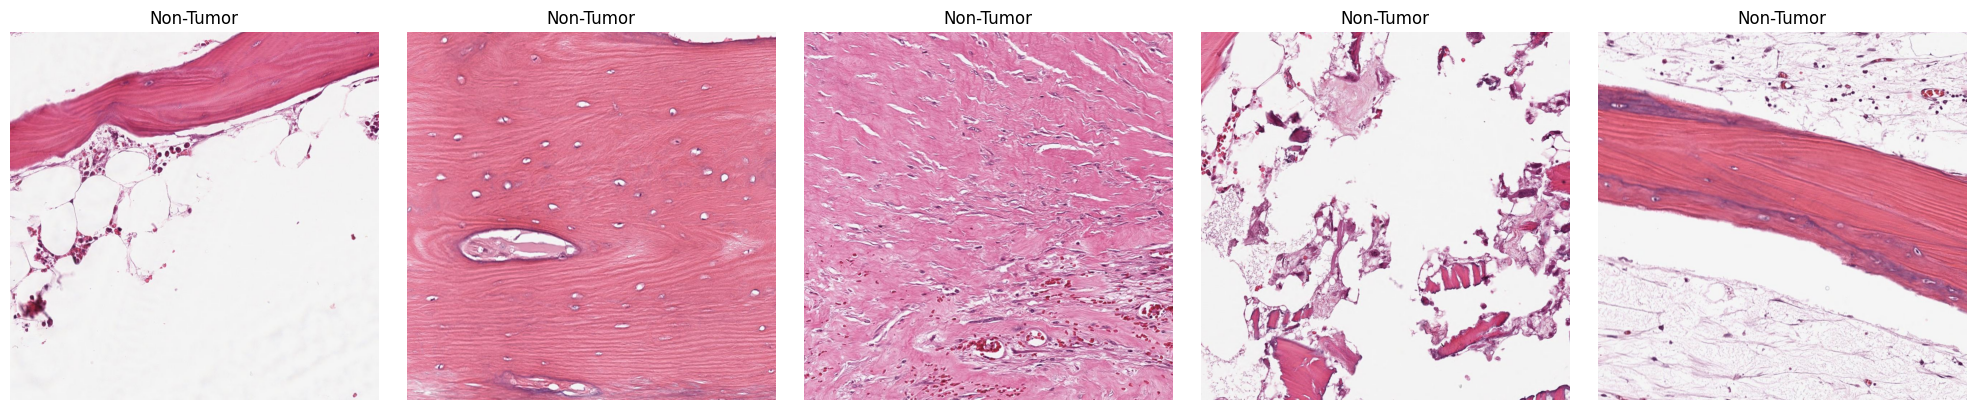

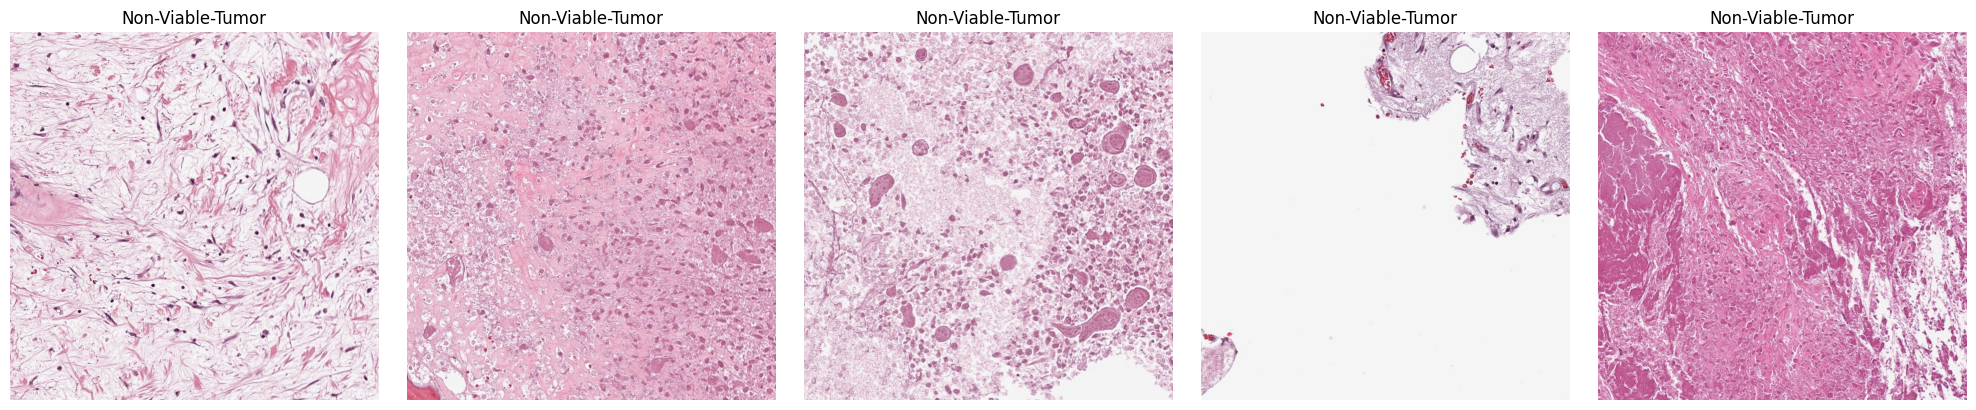

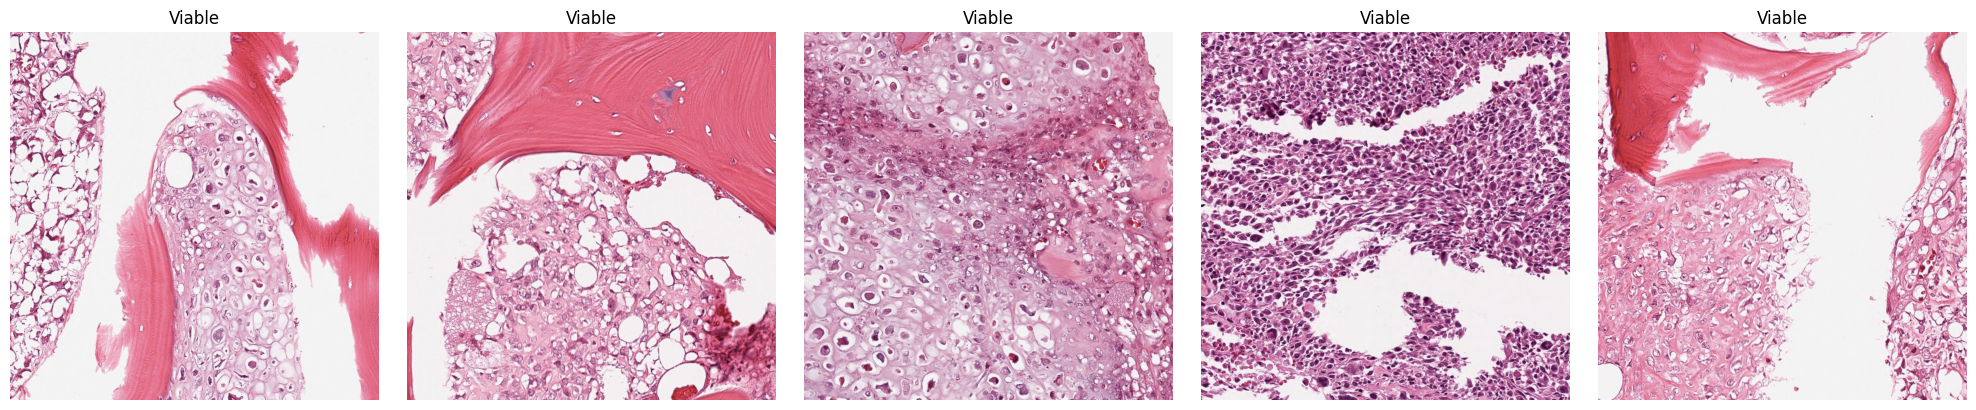

In [8]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2

def count_images_per_class(base_path):
    class_counts = defaultdict(int)
    
    if not os.path.exists(base_path):
        print(f"Warning: Path not found: {base_path}")
        return {}

    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_path):
            num_files = sum(
                1 for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            )
            class_counts[class_folder] = num_files

    return dict(class_counts)

def show_images(base_path, class_name, num_images=5):
    class_path = os.path.join(base_path, class_name)
    
    if not os.path.exists(class_path):
        print(f"Class directory not found: {class_path}")
        return
    
    all_files = [
        f for f in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, f)) and not f.startswith('.')
    ]
    
    if not all_files:
        print(f"No images found in {class_path}")
        return
    
    images = all_files[:num_images]

    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    
    if len(images) == 1:
        axes = [axes]
    
    for ax, img_name in zip(axes, images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            ax.axis('off')
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_name)

    plt.tight_layout()
    plt.show()

# Define dataset_path here if not already defined
dataset_path = "/kaggle/input/osteosarcoma/dataset"

# Define train_counts before use
train_counts = count_images_per_class(os.path.join(dataset_path, "train"))

train_path = os.path.join(dataset_path, "train")
for class_name in train_counts.keys():
    show_images(train_path, class_name)


# 2. Data Preprocessing 
## 2.1 Define Augmentation Pipeline - applying rotation, flipping, brightness adjustment, and zoom blur.
## 2.2 Define Preprocessing Function - Resize to 224x224 pixels., Normalize pixel values between 0 and 1, Apply augmentation to balance the dataset.
## 2.3 Compute Class Weights for Training
## 2.4 Convert NumPy Arrays to TensorFlow Tensors

In [2]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import cv2
import tensorflow as tf
import albumentations as A
from sklearn.utils.class_weight import compute_class_weight

# Verify dataset exists
dataset_path = "/kaggle/input/osteosarcoma/dataset"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Verify the correct path!")

train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validate")
test_dir = os.path.join(dataset_path, "test")

# Define output directory for preprocessed data
preprocessed_dir = "/kaggle/working/preprocessed_osteosarcoma"
for split in ["train", "validate", "test"]:
    os.makedirs(os.path.join(preprocessed_dir, split), exist_ok=True)

# Albumentations augmentation pipeline
augmentations = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ZoomBlur(max_factor=1.1, p=0.3),
])

def augment_data(images, target_count):
    augmented_images = []
    if len(images) == 0:
        return np.array([])
    while len(augmented_images) + len(images) < target_count:
        img = images[np.random.randint(0, len(images))]
        # Albumentations expects uint8 images
        augmented = augmentations(image=(img * 255).astype(np.uint8))
        aug_img = augmented["image"] / 255.0  # Normalize back to 0-1
        augmented_images.append(aug_img)
    return np.array(augmented_images, dtype=np.float32)

def preprocess_and_save_numpy_balanced(base_dir, output_dir, dataset_name):
    X, y = [], []
    class_counts = {}

    # First get all classes and counts to find max class count for augmentation
    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    max_class_count = 0
    images_per_class = {}

    # Load all images first
    for class_name in classes:
        class_path = os.path.join(base_dir, class_name)
        images = []
        for img_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}")
                continue
            img = cv2.resize(img, (224, 224))
            img = img / 255.0
            images.append(img)
        images_per_class[class_name] = images
        max_class_count = max(max_class_count, len(images))

    # Augment minority classes and build final dataset
    for label, class_name in enumerate(classes):
        images = images_per_class[class_name]
        count = len(images)
        class_counts[class_name] = count

        # Save class directory in output path
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        # Append original images
        X.extend(images)
        y.extend([label] * count)

        # Augment if needed
        if count < max_class_count:
            extra_augmented = augment_data(images, max_class_count)
            X.extend(extra_augmented)
            y.extend([label] * len(extra_augmented))

    # Convert to numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # Save arrays
    np.save(os.path.join(preprocessed_dir, f"X_{dataset_name}.npy"), X)
    np.save(os.path.join(preprocessed_dir, f"y_{dataset_name}.npy"), y)

    print(f"Saved balanced {dataset_name} dataset: {X.shape[0]} samples")

    return X, y

# Process datasets
X_train, y_train = preprocess_and_save_numpy_balanced(train_dir, os.path.join(preprocessed_dir, "train"), "train")
X_val, y_val = preprocess_and_save_numpy_balanced(val_dir, os.path.join(preprocessed_dir, "validate"), "validate")
X_test, y_test = preprocess_and_save_numpy_balanced(test_dir, os.path.join(preprocessed_dir, "test"), "test")

# Compute and save class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Computed class weights:", class_weights_dict)
np.save(os.path.join(preprocessed_dir, "class_weights.npy"), class_weights_dict)

# Convert numpy arrays to TF tensors and save
def save_tf_tensors(X, y, name):
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
    np.save(os.path.join(preprocessed_dir, f"X_{name}_tensor.npy"), X_tensor.numpy())
    np.save(os.path.join(preprocessed_dir, f"y_{name}_tensor.npy"), y_tensor.numpy())

save_tf_tensors(X_train, y_train, "train")
save_tf_tensors(X_val, y_val, "validate")
save_tf_tensors(X_test, y_test, "test")

# Zip preprocessed data for download convenience
zip_path = "/kaggle/working/preprocessed_osteosarcoma.zip"
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', preprocessed_dir)

print(f"Preprocessed data zipped at {zip_path}")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Loading Viable: 100%|██████████| 156/156 [00:03<00:00, 46.55it/s]


Saved balanced train dataset: 1020 samples


Loading Viable: 100%|██████████| 77/77 [00:01<00:00, 46.42it/s]


Saved balanced validate dataset: 264 samples


Loading Viable: 100%|██████████| 44/44 [00:00<00:00, 47.21it/s]


Saved balanced test dataset: 273 samples
Computed class weights: {0: 1.0, 1: 1.0, 2: 1.0}


I0000 00:00:1747319336.598596      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747319336.599281      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Preprocessed data zipped at /kaggle/working/preprocessed_osteosarcoma.zip


# 3. Exploratory Data Analysis

## 3.1 Class Distribution After Preprocessing
## 3.2 Visualizing Preprocessed Images
## 3.3 Pixel Intensity Distribution (Histogram)
## 3.4 Dataset Shape & Validation
## 3.5 Mean and Standard Deviation of Pixel Intensities
## 3.6 Correlation Between Image Classes (One-Hot Encoding)
## 3.7 Check for Class Imbalance (Pie Chart)
## 3.8 Pixel Intensity Comparison Between Classes
## 3.9 Brightness Distribution
## 3.10 Aspect Ratio Analysis
## 3.11 RGB Channel Mean Analysis



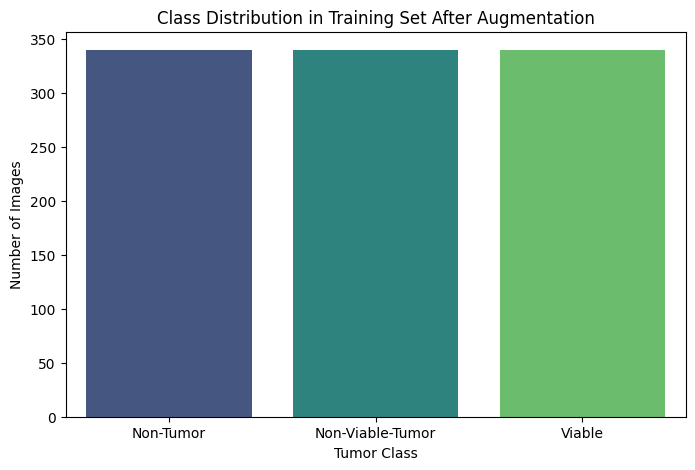

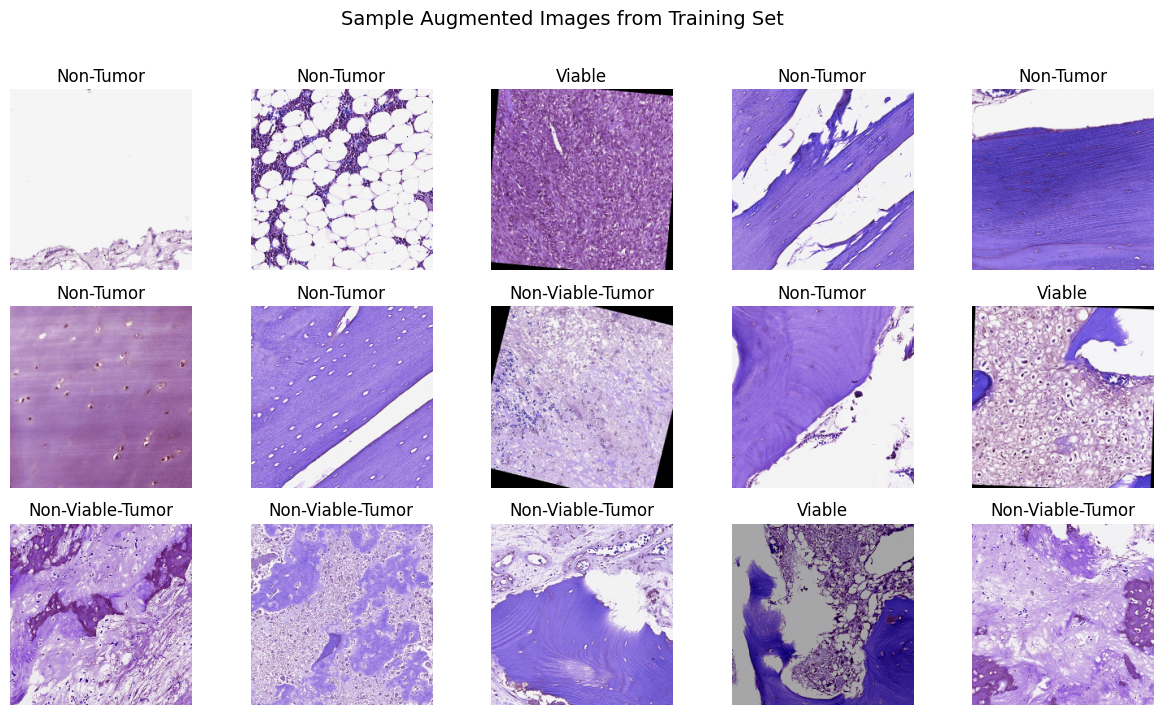

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


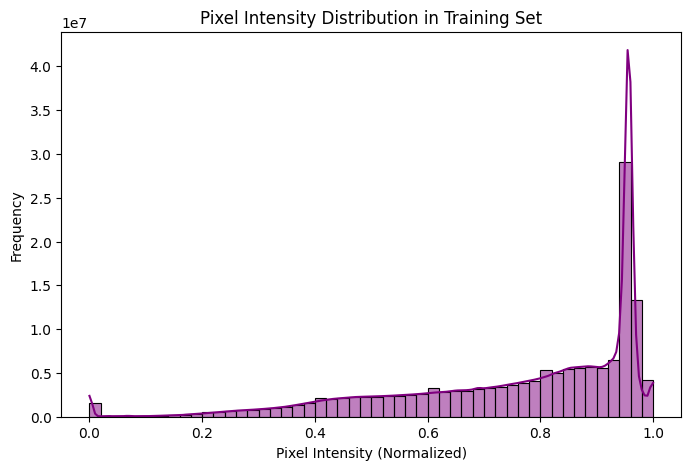

Dataset Overview:
   Dataset   Image Shape  Total Images  Classes
     Train (224, 224, 3)          1020        3
Validation (224, 224, 3)           264        3
      Test (224, 224, 3)           273        3

Mean Pixel Intensity: 0.7616
Standard Deviation of Pixel Intensities: 0.2180


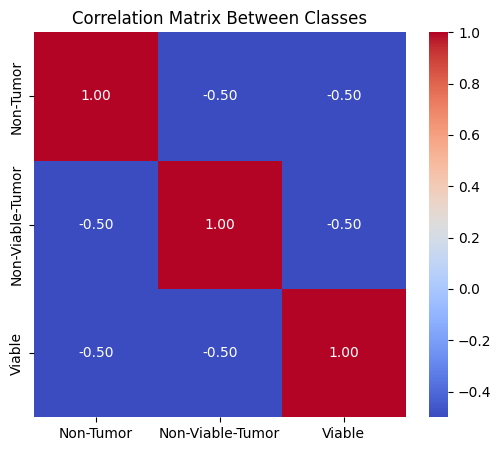


Label Distribution in Training Set:
Non-Tumor: 340 images
Non-Viable-Tumor: 340 images
Viable: 340 images


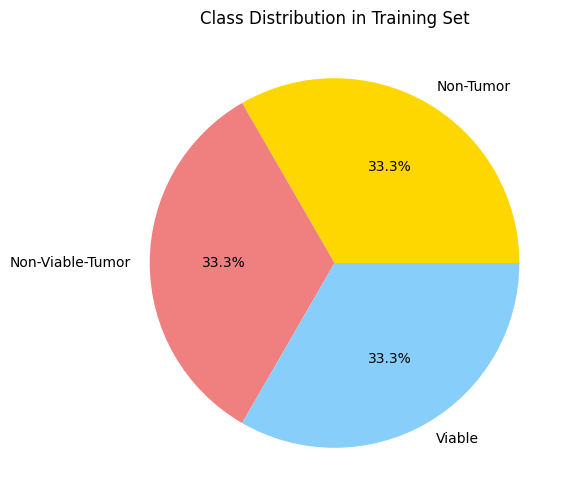

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


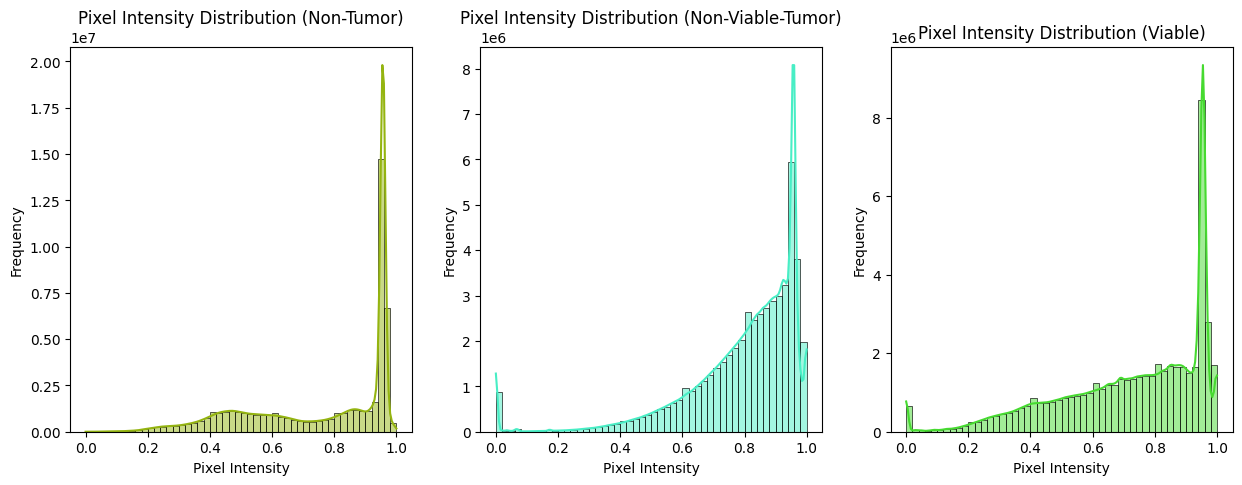

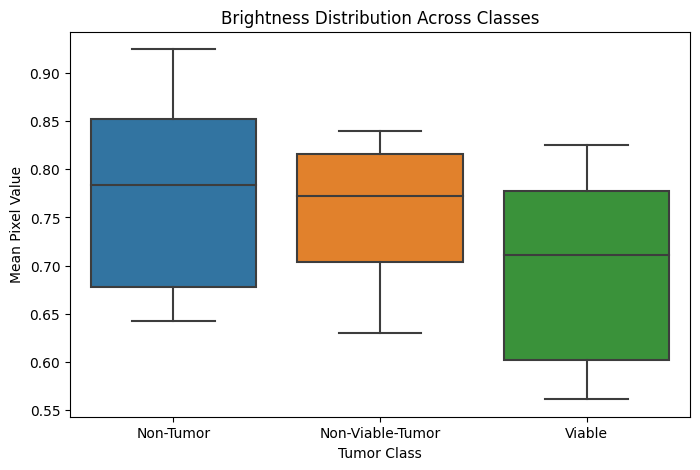

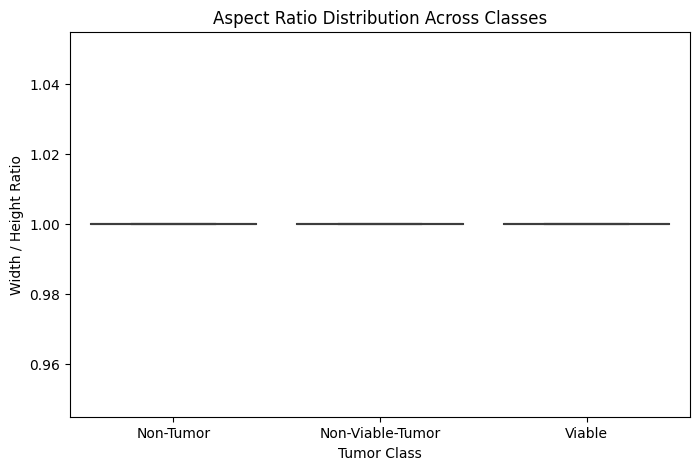

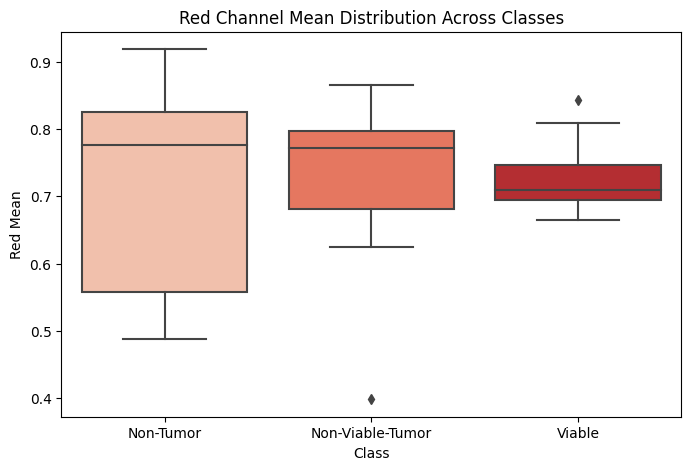

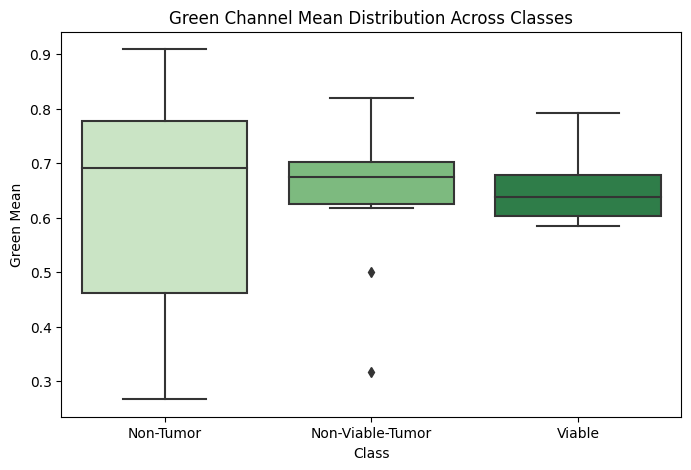

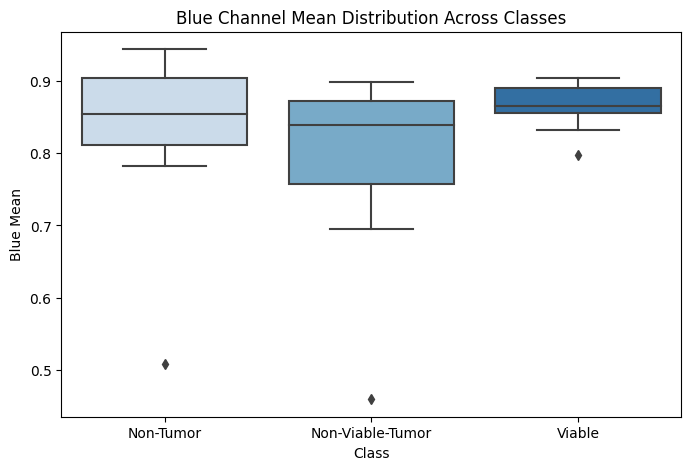

Exploratory Data Analysis (EDA) is complete!


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Load preprocessed dataset
preprocessed_dir = "/kaggle/working/preprocessed_osteosarcoma"

# Verify if files exist before loading
if not os.path.exists(preprocessed_dir):
    raise FileNotFoundError(f"Preprocessed directory not found at {preprocessed_dir}. Verify preprocessing!")

X_train = np.load(os.path.join(preprocessed_dir, "X_train_tensor.npy"))
y_train = np.load(os.path.join(preprocessed_dir, "y_train_tensor.npy"))

# Corrected validation file names
X_val = np.load(os.path.join(preprocessed_dir, "X_validate_tensor.npy"))
y_val = np.load(os.path.join(preprocessed_dir, "y_validate_tensor.npy"))

X_test = np.load(os.path.join(preprocessed_dir, "X_test_tensor.npy"))
y_test = np.load(os.path.join(preprocessed_dir, "y_test_tensor.npy"))

# Define class labels
class_labels = ["Non-Tumor", "Non-Viable-Tumor", "Viable"]


# Class Distribution After Augmentation
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette="viridis")
plt.xticks(ticks=[0, 1, 2], labels=class_labels)
plt.title("Class Distribution in Training Set After Augmentation")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.show()

# **Visualizing Augmented Images**
fig, axes = plt.subplots(3, 5, figsize=(15, 8))
fig.suptitle("Sample Augmented Images from Training Set", fontsize=14)

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(class_labels[y_train[idx]])
    ax.axis("off")

plt.show()

# Pixel Intensity Distribution (Histogram)
plt.figure(figsize=(8, 5))
sns.histplot(X_train.flatten(), bins=50, kde=True, color='purple')
plt.title("Pixel Intensity Distribution in Training Set")
plt.xlabel("Pixel Intensity (Normalized)")
plt.ylabel("Frequency")
plt.show()

# 4️⃣ **Dataset Shape & Validation**
dataset_info = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Image Shape": [X_train.shape[1:], X_val.shape[1:], X_test.shape[1:]],
    "Total Images": [X_train.shape[0], X_val.shape[0], X_test.shape[0]],
    "Classes": [len(set(y_train)), len(set(y_val)), len(set(y_test))],
})

# Display dataset information
print("Dataset Overview:")
print(dataset_info.to_string(index=False))

# Mean and Standard Deviation of Pixel Intensities
mean_intensity = np.mean(X_train)
std_intensity = np.std(X_train)

print(f"\nMean Pixel Intensity: {mean_intensity:.4f}")
print(f"Standard Deviation of Pixel Intensities: {std_intensity:.4f}")

# Correlation Between Image Classes (One-Hot Encoding)
y_train_one_hot = pd.get_dummies(y_train)
correlation_matrix = y_train_one_hot.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Correlation Matrix Between Classes")
plt.show()

# Check for Any Duplicates in Labels
unique_labels, label_counts = np.unique(y_train, return_counts=True)
print("\nLabel Distribution in Training Set:")
for label, count in zip(unique_labels, label_counts):
    print(f"{class_labels[label]}: {count} images")

# Check for Class Imbalance (Pie Chart)
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=class_labels, autopct="%1.1f%%", colors=["gold", "lightcoral", "lightskyblue"])
plt.title("Class Distribution in Training Set")
plt.show()

# Pixel Intensity Comparison Between Classes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, class_label in enumerate(class_labels):
    class_indices = np.where(y_train == i)[0]
    class_pixels = X_train[class_indices].flatten()

    sns.histplot(class_pixels, bins=50, kde=True, ax=axes[i], color=np.random.rand(3,))
    axes[i].set_title(f"Pixel Intensity Distribution ({class_label})")
    axes[i].set_xlabel("Pixel Intensity")
    axes[i].set_ylabel("Frequency")

plt.show()

# Brightness Distribution (Mean Pixel Value per Image)
brightness_values = {class_name: [] for class_name in class_labels}

for i, class_name in enumerate(class_labels):
    class_indices = np.where(y_train == i)[0]
    sample_images = np.random.choice(class_indices, size=min(10, len(class_indices)), replace=False)

    for idx in sample_images:
        img = X_train[idx]
        brightness_values[class_name].append(np.mean(img))

# Convert brightness values to DataFrame
df_brightness = pd.DataFrame(brightness_values)

# Plot Brightness Distribution
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_brightness)
plt.title("Brightness Distribution Across Classes")
plt.ylabel("Mean Pixel Value")
plt.xlabel("Tumor Class")
plt.xticks(ticks=[0, 1, 2], labels=class_labels)
plt.show()

# Aspect Ratio Analysis
aspect_ratios = {class_name: [] for class_name in class_labels}

for i, class_name in enumerate(class_labels):
    class_indices = np.where(y_train == i)[0]
    sample_images = np.random.choice(class_indices, size=min(10, len(class_indices)), replace=False)

    for idx in sample_images:
        img = X_train[idx]
        h, w, _ = img.shape
        aspect_ratios[class_name].append(w / h)

# Convert aspect ratios to DataFrame
df_aspect_ratios = pd.DataFrame(aspect_ratios)

# Plot Aspect Ratio Distribution
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_aspect_ratios)
plt.title("Aspect Ratio Distribution Across Classes")
plt.ylabel("Width / Height Ratio")
plt.xlabel("Tumor Class")
plt.xticks(ticks=[0, 1, 2], labels=class_labels)
plt.show()

# RGB Channel Mean Analysis
channel_means = {class_name: [] for class_name in class_labels}

for i, class_name in enumerate(class_labels):
    class_indices = np.where(y_train == i)[0]
    sample_images = np.random.choice(class_indices, size=min(10, len(class_indices)), replace=False)

    for idx in sample_images:
        img = X_train[idx]
        r_mean, g_mean, b_mean = np.mean(img[:, :, 0]), np.mean(img[:, :, 1]), np.mean(img[:, :, 2])
        channel_means[class_name].append([r_mean, g_mean, b_mean])

df_channel_means = pd.DataFrame({
    "Class": np.repeat(class_labels, 10),
    "Red Mean": np.concatenate([np.array(channel_means[c])[:, 0] for c in class_labels]),
    "Green Mean": np.concatenate([np.array(channel_means[c])[:, 1] for c in class_labels]),
    "Blue Mean": np.concatenate([np.array(channel_means[c])[:, 2] for c in class_labels]),
})

# Plot RGB Means
plt.figure(figsize=(8, 5))
sns.boxplot(x="Class", y="Red Mean", data=df_channel_means, palette="Reds")
plt.title("Red Channel Mean Distribution Across Classes")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x="Class", y="Green Mean", data=df_channel_means, palette="Greens")
plt.title("Green Channel Mean Distribution Across Classes")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x="Class", y="Blue Mean", data=df_channel_means, palette="Blues")
plt.title("Blue Channel Mean Distribution Across Classes")
plt.show()

#EDA Completed!
print("Exploratory Data Analysis (EDA) is complete!")


# 4. HyPerNet: Hybrid ResNet50-EfficientNetB0 with LSTM-GRU Fusion
## 4.1 Model Training

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Concatenate, Dropout, BatchNormalization,
    Bidirectional, LSTM, GRU, GlobalAveragePooling2D, Reshape
)
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os

# Enable Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Load Dataset
preprocessed_dir = "/kaggle/input/preprocessed-osteosarcoma/preprocessed_osteosarcoma"
X_train = np.load(os.path.join(preprocessed_dir, "X_train_tensor.npy"))
y_train = np.load(os.path.join(preprocessed_dir, "y_train_tensor.npy"))
X_val = np.load(os.path.join(preprocessed_dir, "X_validate_tensor.npy"))
y_val = np.load(os.path.join(preprocessed_dir, "y_validate_tensor.npy"))
X_test = np.load(os.path.join(preprocessed_dir, "X_test_tensor.npy"))
y_test = np.load(os.path.join(preprocessed_dir, "y_test_tensor.npy"))

# Input Shape and Classes
input_shape = (224, 224, 3)
num_classes = 3

# Model Inputs
resnet_input = Input(shape=input_shape, name="resnet_input")
effnet_input = Input(shape=input_shape, name="effnet_input")

# Load Pretrained Base CNNs
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=resnet_input)
efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=effnet_input)

# Freeze All Except BatchNorm Layers
for layer in resnet.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
for layer in efficientnet.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Extract CNN Features
resnet_features = GlobalAveragePooling2D()(resnet.output)
efficientnet_features = GlobalAveragePooling2D()(efficientnet.output)

# Reshape for RNN Layers
resnet_reshape = Reshape((1, 2048))(resnet_features)
effnet_reshape = Reshape((1, 1280))(efficientnet_features)

# RNN Layers
resnet_lstm = Bidirectional(LSTM(128, return_sequences=False))(resnet_reshape)
effnet_gru = GRU(128, return_sequences=False)(effnet_reshape)

# Merge Features
merged = Concatenate()([resnet_lstm, effnet_gru])

# Fully Connected Layers
x = Dense(256, activation="relu")(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output Layer (float32 to avoid dtype issues)
output = Dense(num_classes, activation="softmax", dtype="float32")(x)

# Define Model
hybrid_model = Model(inputs=[resnet_input, effnet_input], outputs=output)

# Compile Model
hybrid_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

def augment_images(X_data):
    return np.array([datagen.random_transform(img) for img in X_data])

# Augment Data Separately for Dual Inputs
X_train_resnet = augment_images(X_train)
X_train_effnet = augment_images(X_train)
X_val_resnet = augment_images(X_val)
X_val_effnet = augment_images(X_val)
X_test_resnet = augment_images(X_test)
X_test_effnet = augment_images(X_test)

# Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the Model
history = hybrid_model.fit(
    [X_train_resnet, X_train_effnet], y_train,
    validation_data=([X_val_resnet, X_val_effnet], y_val),
    epochs=30,
    batch_size=16,
    class_weight=class_weights_dict,
    verbose=1
)

# Save History
np.save("/kaggle/working/training_history.npy", history.history)

# Evaluate on Test Data
test_loss, test_accuracy = hybrid_model.evaluate([X_test_resnet, X_test_effnet], y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the Model
hybrid_model.save("/kaggle/working/optimized_hybrid_cnn_rnn_model.h5")


I0000 00:00:1747493279.707760      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747493279.708530      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


I0000 00:00:1747493408.714198      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 533ms/step - accuracy: 0.4323 - loss: 1.5295 - val_accuracy: 0.3333 - val_loss: 1.1714
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.7613 - loss: 0.6066 - val_accuracy: 0.3333 - val_loss: 1.2762
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.8354 - loss: 0.4513 - val_accuracy: 0.3333 - val_loss: 1.3870
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.8485 - loss: 0.3900 - val_accuracy: 0.3333 - val_loss: 1.5296
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.8829 - loss: 0.3121 - val_accuracy: 0.3333 - val_loss: 1.7638
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.8917 - loss: 0.2748 - val_accuracy: 0.3333 - val_loss: 2.0567
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.9029 - loss: 0.2648 - val_accuracy: 0.3220 - val_loss: 2.2563
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 336ms/step - accuracy: 0.9062 - loss: 0.2859 - val_accuracy: 0.33

## 4.2 Saving the model in keras format

In [7]:
import tensorflow as tf

# Define the path for the new format
saved_model_path = "/kaggle/working/optimized_hybrid_cnn_rnn_model.keras"

# Save the model in `.keras` format (instead of `SavedModel` or `.h5`)
hybrid_model.save(saved_model_path)

print("Model successfully saved in `.keras` format!")


Model successfully saved in `.keras` format!


## 4.3 Loading the model from Keras Format

In [8]:
import tensorflow as tf

# Load the model from `.keras` format
model_path = "/kaggle/working/optimized_hybrid_cnn_rnn_model.keras"
hybrid_model = tf.keras.models.load_model(model_path)

print(" Model successfully loaded from `.keras` format!")


 Model successfully loaded from `.keras` format!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 229 variables whereas the saved optimizer has 452 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 225 variables whereas the saved optimizer has 448 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 4.4 Model Evaluation

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 860ms/step

Classification Report:

                  precision    recall  f1-score   support

       Non-Tumor       0.86      0.98      0.92        91
Non-Viable-Tumor       0.97      0.91      0.94        91
          Viable       0.99      0.91      0.95        91

        accuracy                           0.93       273
       macro avg       0.94      0.93      0.93       273
    weighted avg       0.94      0.93      0.93       273



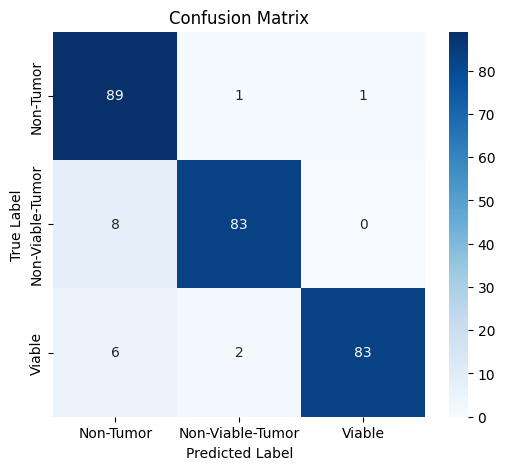

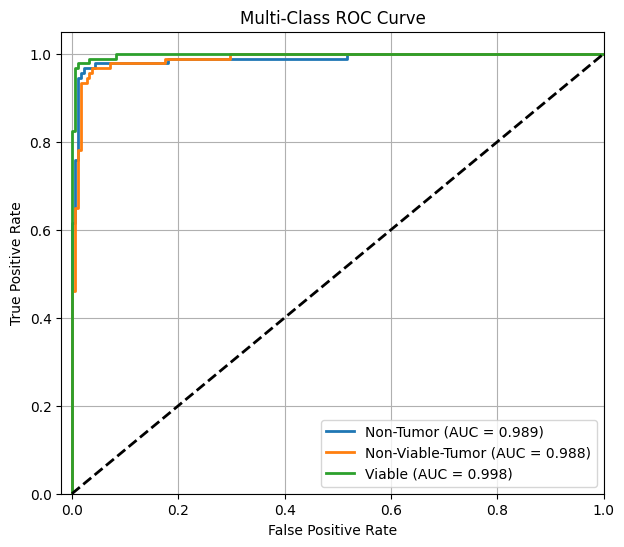

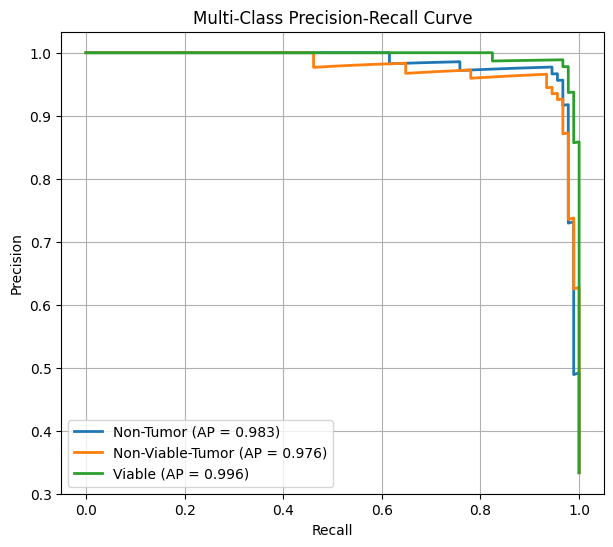

Macro F1-score: 0.9347


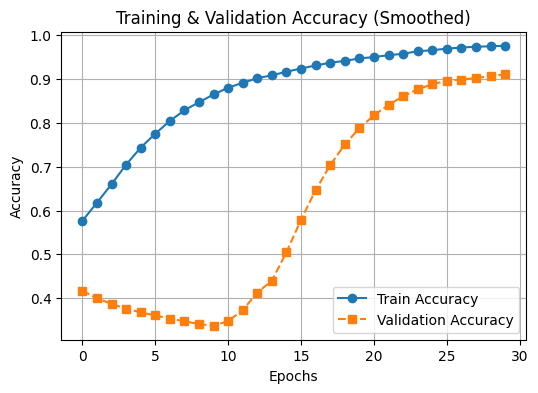

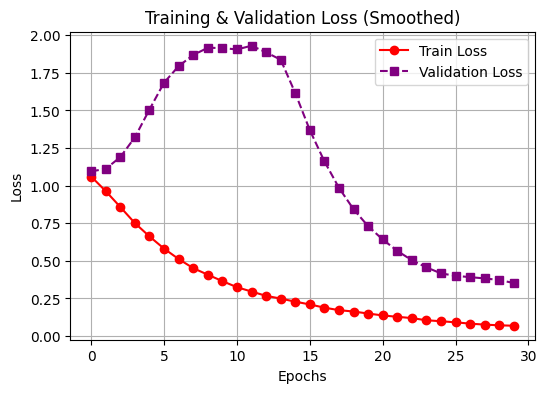

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, roc_curve, auc, confusion_matrix, 
    precision_recall_curve, average_precision_score, f1_score
)
import os

# Dataset path based on screenshot
preprocessed_dir = "/kaggle/input/preprocessed-osteosarcoma/preprocessed_osteosarcoma"

if not os.path.exists(preprocessed_dir):
    raise FileNotFoundError(f"Preprocessed directory not found at {preprocessed_dir}")

X_test = np.load(os.path.join(preprocessed_dir, "X_test_tensor.npy"))
y_test = np.load(os.path.join(preprocessed_dir, "y_test_tensor.npy"))

# Predict
y_pred_probs = hybrid_model.predict([X_test, X_test])
if np.isnan(y_pred_probs).any():
    y_pred_probs = np.nan_to_num(y_pred_probs)

# One-hot encode for ROC/PR
num_classes = len(np.unique(y_test))
y_test_onehot = np.eye(num_classes)[y_test]
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = ["Non-Tumor", "Non-Viable-Tumor", "Viable"]

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_labels, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC curves
plt.figure(figsize=(7, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall curves
plt.figure(figsize=(7, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    ap_score = average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_labels[i]} (AP = {ap_score:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Macro F1
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")

# Training history
history_path = "/kaggle/working/training_history.npy"

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

if os.path.exists(history_path):
    history = np.load(history_path, allow_pickle=True).item()

    plt.figure(figsize=(6, 4))
    plt.plot(smooth_curve(history["accuracy"]), label="Train Accuracy", marker="o")
    plt.plot(smooth_curve(history["val_accuracy"]), label="Validation Accuracy", linestyle="dashed", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy (Smoothed)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(smooth_curve(history["loss"]), label="Train Loss", marker="o", color="red")
    plt.plot(smooth_curve(history["val_loss"]), label="Validation Loss", linestyle="dashed", marker="s", color="purple")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss (Smoothed)")
    plt.legend()
    plt.grid(True)
    plt.show()


# 5. CNN model
## 5.1 Model Training

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load preprocessed data from correct path
data_path = "/kaggle/input/preprocessed-osteosarcoma/preprocessed_osteosarcoma/"

X_train = np.load(data_path + "X_train_tensor.npy")
y_train = np.load(data_path + "y_train_tensor.npy")

X_val = np.load(data_path + "X_validate_tensor.npy")
y_val = np.load(data_path + "y_validate_tensor.npy")

X_test = np.load(data_path + "X_test_tensor.npy")
y_test = np.load(data_path + "y_test_tensor.npy")

class_weights = np.load(data_path + "class_weights.npy", allow_pickle=True).item()

# Define CNN model
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # helps reduce overfitting
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
input_shape = X_train.shape[1:]
cnn_model = build_cnn_model(input_shape)

history = cnn_model.fit(
    X_train, y_train,
    epochs=20,  # increased for better learning
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
)

# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.3140 - loss: 5.0794 - val_accuracy: 0.5985 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4510 - loss: 0.9922 - val_accuracy: 0.6023 - val_loss: 0.9581 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5969 - loss: 0.8582 - val_accuracy: 0.6894 - val_loss: 0.8771 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6377 - loss: 0.8315 - val_accuracy: 0.5076 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6112 - loss: 0.8131 - val_accuracy: 0.7083 - val_loss: 0.9440 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7158 - loss: 0.7049 - val_accuracy: 0.7386 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7600 - loss: 0.6016 - val_ac

## 5.2 Saving the model

In [14]:
# Save the trained model
cnn_model.save("/kaggle/working/osteosarcoma_cnn_model.h5")

## 5.3 Testing on sample data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


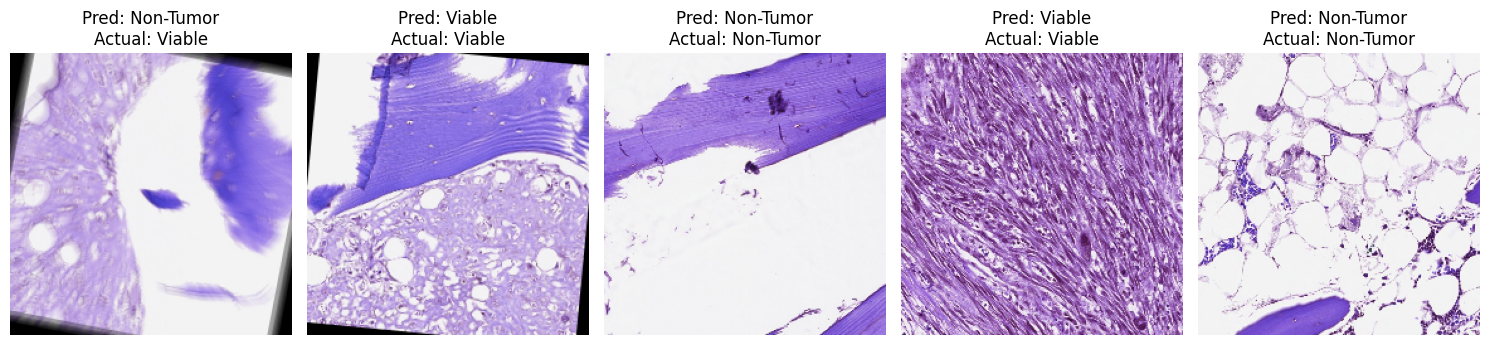

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np

class_names = {0: "Non-Tumor", 1: "Non-Viable-Tumor", 2: "Viable"}

# Pick 5 random indices
sample_indices = random.sample(range(len(X_test)), 5)

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    actual_label = int(y_test[idx])  # ensure it's an int
    
    predicted_prob = cnn_model.predict(np.expand_dims(img, axis=0))
    predicted_label = np.argmax(predicted_prob)

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {class_names[predicted_label]}\nActual: {class_names[actual_label]}")

plt.tight_layout()
plt.show()


# 6. CNN + GCN Model
## 6.1 Load Pretrained CNN (ResNet50) and Feature Extraction

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import normalize
from tqdm import tqdm

# 1. Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Load Pretrained ResNet50 and Remove Fully Connected Layer
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])  # Remove final FC layer
resnet50.to(device)
resnet50.eval()

# 3. Image Preprocessing (to match ResNet50 expectations)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure size compatibility
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Feature Extraction Function
def extract_features(model, data, batch_size=16):
    # Convert to Tensor and move channel to front: (N, H, W, C) -> (N, C, H, W)
    data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)

    features_list = []
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            batch = preprocess(batch) if preprocess else batch
            batch = batch.to(device)
            output = model(batch)
            output = output.view(output.size(0), -1).cpu().numpy()  # Flatten
            features_list.append(output)

    return np.vstack(features_list)

# 5. Load Your Preprocessed Tensors from Dataset
data_path = "/kaggle/input/preprocessed-osteosarcoma/preprocessed_osteosarcoma/"
X_train = np.load(data_path + "X_train_tensor.npy")
X_val = np.load(data_path + "X_validate_tensor.npy")
X_test = np.load(data_path + "X_test_tensor.npy")

# 6. Extract CNN Features
X_train_features = extract_features(resnet50, X_train, batch_size=32)
X_val_features = extract_features(resnet50, X_val, batch_size=32)
X_test_features = extract_features(resnet50, X_test, batch_size=32)

# 7. Normalize the Features (L2)
X_train_features = normalize(X_train_features, axis=1)
X_val_features = normalize(X_val_features, axis=1)
X_test_features = normalize(X_test_features, axis=1)

print("CNN Features Extracted:")
print("Train:", X_train_features.shape)
print("Val:", X_val_features.shape)
print("Test:", X_test_features.shape)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s] 
Extracting features: 100%|██████████| 9/9 [00:00<00:00, 10.62it/s]

CNN Features Extracted:
Train: (1020, 2048)
Val: (264, 2048)
Test: (273, 2048)


## 6.2 Create Graph from CNN Features

In [7]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load Labels from Dataset
data_path = "/kaggle/input/preprocessed-osteosarcoma/preprocessed_osteosarcoma/"
y_train = np.load(data_path + "y_train_tensor.npy")

# Use Extracted CNN Features as Node Features
features = X_train_features  # Already extracted & normalized
num_images = features.shape[0]

# Ensure Label Array Matches Feature Count
if len(y_train) != num_images:
    raise ValueError(f"Mismatch: {len(y_train)} labels vs {num_images} features")

# Create Graph
graph = nx.Graph()

# Add Nodes with Features and Labels
for i in range(num_images):
    graph.add_node(i, feature=features[i], label=int(y_train[i]))

print(f"{num_images} nodes added with features and labels")

# Normalize Features Again (if needed)
features_norm = features / np.linalg.norm(features, axis=1, keepdims=True)

# Compute Pairwise Cosine Similarities
print("Computing cosine similarity matrix...")
similarity_matrix = cosine_similarity(features_norm)

# Set Similarity Threshold
threshold = 0.7

# Add Edges for Pairs Above Threshold
edge_count = 0
for i in range(num_images):
    for j in range(i + 1, num_images):
        if similarity_matrix[i, j] > threshold:
            graph.add_edge(i, j, weight=similarity_matrix[i, j])
            edge_count += 1

print(f"Graph created with {graph.number_of_nodes()} nodes and {edge_count} edges")

# Print Label Distribution
node_labels = np.array([graph.nodes[n]['label'] for n in graph.nodes])
unique_labels, label_counts = np.unique(node_labels, return_counts=True)
print(f"Unique Labels: {unique_labels.tolist()} - Counts: {label_counts.tolist()}")


1020 nodes added with features and labels
Computing cosine similarity matrix...
Graph created with 1020 nodes and 215762 edges
Unique Labels: [0, 1, 2] - Counts: [340, 340, 340]


## 6.3 Convert Graph to PyTorch Geometric Format

In [10]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx

# Extract adjacency matrix from NetworkX graph
adj_matrix = nx.to_numpy_array(graph)

# Convert adjacency matrix to edge index (COO format)
edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)

# Extract CNN-based node features
node_features = np.array([graph.nodes[n]['feature'] for n in graph.nodes])
x = torch.tensor(node_features, dtype=torch.float)

# Standardize features
x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)

# Extract node labels
node_labels = np.array([graph.nodes[n]['label'] for n in graph.nodes])
y = torch.tensor(node_labels, dtype=torch.long)

# Create PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

print(f"Graph converted to PyG format. Nodes: {data.num_nodes}, Edges: {data.num_edges}")
print(f"Label distribution: {torch.bincount(data.y)}")


Graph converted to PyG format. Nodes: 1020, Edges: 431524
Label distribution: tensor([340, 340, 340])


## 6.4 Define the Graph Convolutional Network (GCN)
## 6.5 Train the Model

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model parameters
hidden_dim = 128
num_classes = 3
gcn_model = GCN(in_features=data.x.shape[1], hidden_dim=hidden_dim, out_features=num_classes)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gcn_model = gcn_model.to(device)
data = data.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create train/val split
num_nodes = data.num_nodes
train_idx, val_idx = train_test_split(torch.arange(num_nodes), test_size=0.2, stratify=data.y.cpu())
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

# Training function
def train():
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def evaluate(mask):
    gcn_model.eval()
    with torch.no_grad():
        out = gcn_model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = pred.eq(data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()
    return accuracy

# Training loop
for epoch in range(1, 201):
    loss = train()
    train_acc = evaluate(train_mask)
    val_acc = evaluate(val_mask)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Final accuracy report
final_train_acc = evaluate(train_mask)
final_val_acc = evaluate(val_mask)
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Epoch 001 | Loss: 1.0895 | Train Acc: 0.7598 | Val Acc: 0.7647
Epoch 010 | Loss: 0.5474 | Train Acc: 0.7966 | Val Acc: 0.7892
Epoch 020 | Loss: 0.4986 | Train Acc: 0.8186 | Val Acc: 0.8382
Epoch 030 | Loss: 0.4672 | Train Acc: 0.8260 | Val Acc: 0.8431
Epoch 040 | Loss: 0.4425 | Train Acc: 0.8284 | Val Acc: 0.8480
Epoch 050 | Loss: 0.4289 | Train Acc: 0.8284 | Val Acc: 0.8529
Epoch 060 | Loss: 0.4203 | Train Acc: 0.8419 | Val Acc: 0.8480
Epoch 070 | Loss: 0.4137 | Train Acc: 0.8480 | Val Acc: 0.8431
Epoch 080 | Loss: 0.4087 | Train Acc: 0.8493 | Val Acc: 0.8431
Epoch 090 | Loss: 0.4044 | Train Acc: 0.8444 | Val Acc: 0.8529
Epoch 100 | Loss: 0.4005 | Train Acc: 0.8456 | Val Acc: 0.8578
Epoch 110 | Loss: 0.3970 | Train Acc: 0.8468 | Val Acc: 0.8627
Epoch 120 | Loss: 0.3936 | Train Acc: 0.8493 | Val Acc: 0.8627
Epoch 130 | Loss: 0.3905 | Train Acc: 0.8505 | Val Acc: 0.8627
Epoch 140 | Loss: 0.3876 | Train Acc: 0.8554 | Val Acc: 0.8676
Epoch 150 | Loss: 0.3849 | Train Acc: 0.8578 | Val Acc:

## 6.7 Generate Classification Report
## 6.8 Compute & Plot ROC Curves
## 6.9 Plot Training & Validation Loss and Accuracy Curve

Epoch 001 | Loss: 1.1169 | Train Acc: 0.2757 | Val Acc: 0.2647
Epoch 010 | Loss: 0.5483 | Train Acc: 0.7929 | Val Acc: 0.7990
Epoch 020 | Loss: 0.4938 | Train Acc: 0.8186 | Val Acc: 0.8088
Epoch 030 | Loss: 0.4607 | Train Acc: 0.8162 | Val Acc: 0.8039
Epoch 040 | Loss: 0.4387 | Train Acc: 0.8235 | Val Acc: 0.8284
Epoch 050 | Loss: 0.4260 | Train Acc: 0.8248 | Val Acc: 0.8480
Epoch 060 | Loss: 0.4166 | Train Acc: 0.8297 | Val Acc: 0.8431
Epoch 070 | Loss: 0.4093 | Train Acc: 0.8370 | Val Acc: 0.8382
Epoch 080 | Loss: 0.4038 | Train Acc: 0.8407 | Val Acc: 0.8480
Epoch 090 | Loss: 0.3994 | Train Acc: 0.8419 | Val Acc: 0.8529
Epoch 100 | Loss: 0.3956 | Train Acc: 0.8419 | Val Acc: 0.8529
Epoch 110 | Loss: 0.3922 | Train Acc: 0.8419 | Val Acc: 0.8529
Epoch 120 | Loss: 0.3891 | Train Acc: 0.8456 | Val Acc: 0.8480
Epoch 130 | Loss: 0.3863 | Train Acc: 0.8468 | Val Acc: 0.8529
Epoch 140 | Loss: 0.3836 | Train Acc: 0.8480 | Val Acc: 0.8529
Epoch 150 | Loss: 0.3811 | Train Acc: 0.8456 | Val Acc:

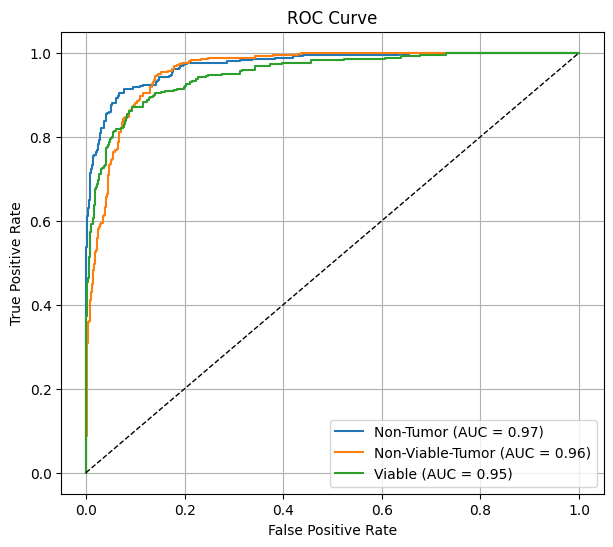

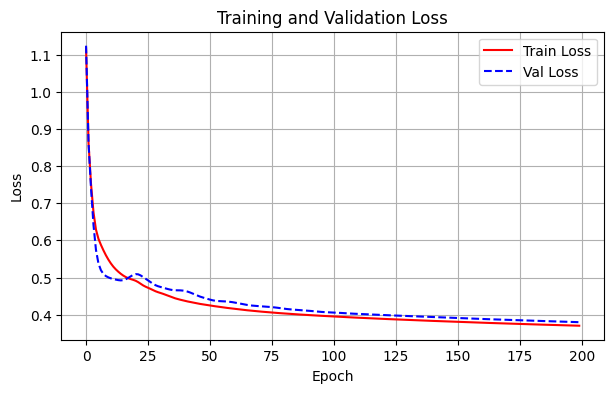

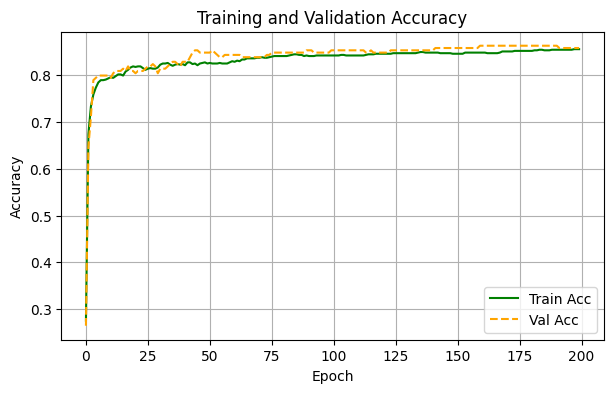

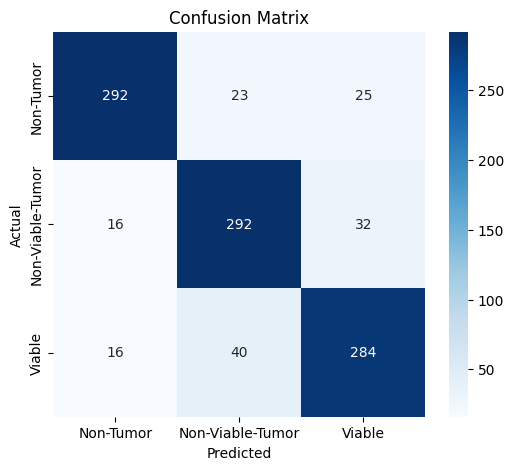

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gcn_model = GCN(data.num_node_features, 128, 3).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create train/validation mask
num_nodes = data.num_nodes
train_idx, val_idx = train_test_split(torch.arange(num_nodes), test_size=0.2, stratify=data.y.cpu())
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

# Trackers (Fixed)
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

best_val_acc = 0
best_model_state = None
best_predictions = None

# Training and evaluation loop
for epoch in range(1, 201):
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Record losses
    training_loss.append(loss.item())
    val_loss = criterion(out[val_mask], data.y[val_mask]).item()
    validation_loss.append(val_loss)

    # Accuracy
    train_pred = out[train_mask].argmax(dim=1)
    val_pred = out[val_mask].argmax(dim=1)
    train_acc = train_pred.eq(data.y[train_mask]).float().mean().item()
    val_acc = val_pred.eq(data.y[val_mask]).float().mean().item()
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)

    # Save best model state
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = gcn_model.state_dict()
        best_predictions = out.argmax(dim=1).cpu()
        best_out = out.detach().cpu()
        best_y_true = data.y.cpu()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Load best model
gcn_model.load_state_dict(best_model_state)

# Classification Report
y_true = best_y_true.numpy()
y_pred = best_predictions.numpy()
class_labels = ["Non-Tumor", "Non-Viable-Tumor", "Viable"]
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# ROC Curve
y_true_onehot = np.eye(len(class_labels))[y_true]
y_probs = torch.exp(best_out).numpy()

plt.figure(figsize=(7, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(7, 4))
plt.plot(training_loss, label="Train Loss", color="red")
plt.plot(validation_loss, label="Val Loss", linestyle="dashed", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Plot
plt.figure(figsize=(7, 4))
plt.plot(training_accuracy, label="Train Acc", color="green")
plt.plot(validation_accuracy, label="Val Acc", linestyle="dashed", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
